In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [31]:
import importlib
importlib.reload(AE_Stats)

<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/AE_Dev/AE_Stats.py'>

In [2]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [3]:
print(f'There are {len(arr)} wafers with sim energy > 0 ')
print(f'mean calcq is: {torch.mean(arr[:,0:48])}')
print(f'max calcq is: {torch.max(arr[:,0:48])}')

There are 892079 wafers with sim energy > 0 
mean calcq is: 16.369503009262633
max calcq is: 10788.0


In [3]:
dt_1 = []


for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    
    
dt_1 = torch.vstack(dt_1).float()


In [4]:
print(f'{len(dt_1)} wafers of type 0')
print(f'mean calcq: {torch.mean(dt_1[:,0:48])}')
print(f'std calcq: {torch.std(dt_1[:,0:48])}')
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])

432654 wafers of type 0
mean calcq: 27.600881576538086
std calcq: 51.770050048828125


In [4]:
dt_1[:,0:48] = (dt_1[:,0:48] - torch.mean(dt_1[:,0:48]))/torch.std(dt_1[:,0:48])


In [6]:
len(dt_1)

432654

In [6]:

size_train =30000
size_test = 20000
train_loc = dt_1[0:size_train]
test_loc = dt_1[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)

train = dt_1[0:size_train,0:48]
test = dt_1[-size_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=100,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=100,
    shuffle=False
)

In [9]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 0.2):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))*std
    
def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))

def AE_MSE_avg(data,pred):
    return torch.mean(torch.max(torch.ones(len(data)),1.5-0.12*((torch.sum(data[:,0:48]**2,dim=1)**0.5)-5.2586)**2)*(torch.sum((data-pred)**2,dim=1)))


def new_loss(data,pred,epoch,mean,std,alpha = 0.2,cut = 25):
    #Reconstruction
    error = dif_weighted_AE_MSE(data,pred,alpha = alpha)
    if epoch < cut:
        return error + std_error(data,pred)
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.sum(torch.norm(sum_dt-sum_pred))
        

        return  error + torch.log(calcQ_Error(data,pred,mean,std))+ 0.1*sum_error*np.min([(epoch-cut)/cut,1])

In [10]:
num_epochs = 20
lr = 0.000045
loss =AE_MSE_avg

MSE 2.9432854652404785
Median 2.7687747478485107
Standard Devitaion 1.6231212615966797
Average std error 8.050989151000977
Average % Error of Energy Reconstruction 8.864349365234375


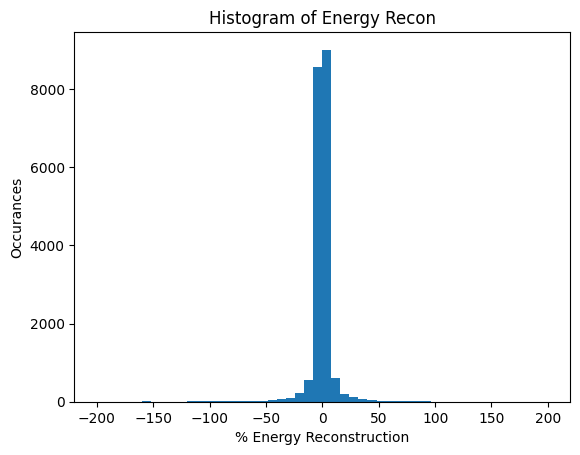

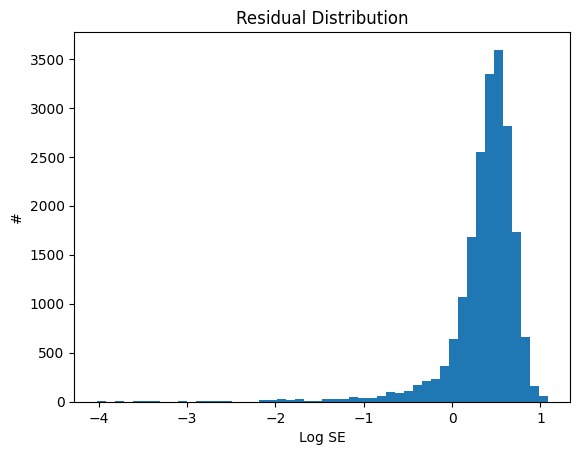

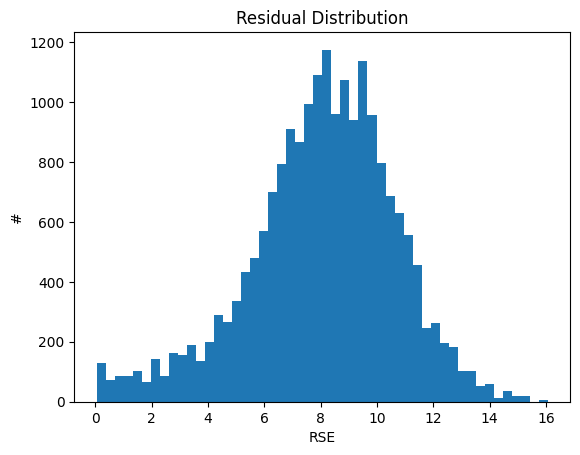

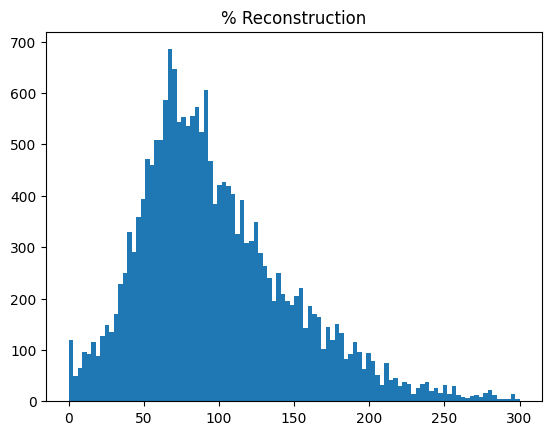

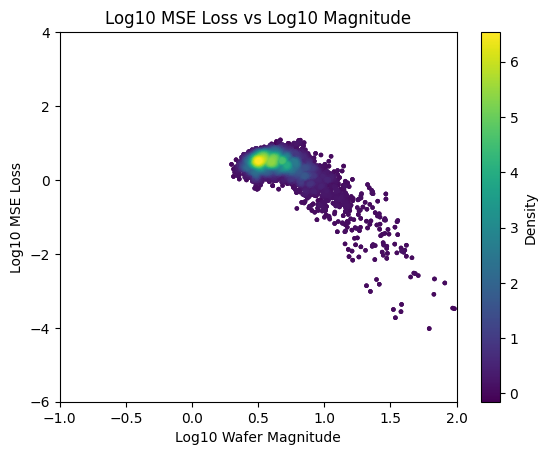

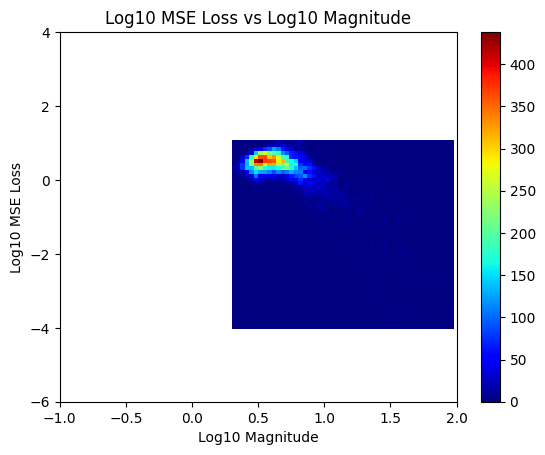

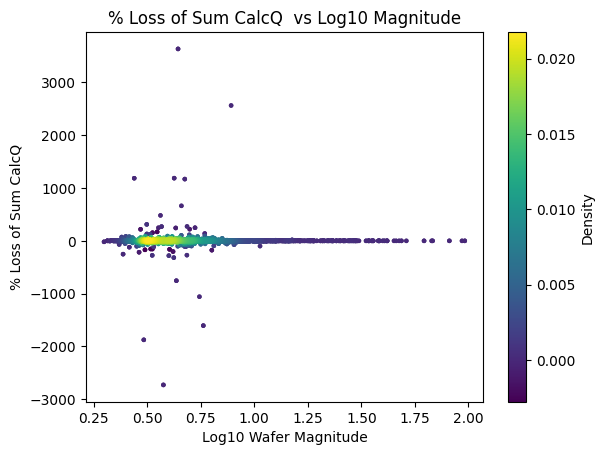

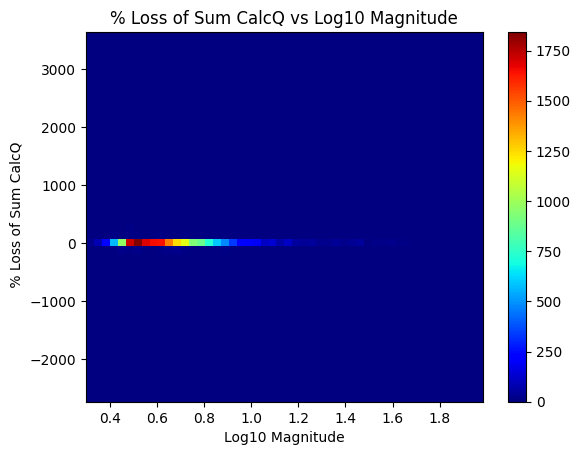

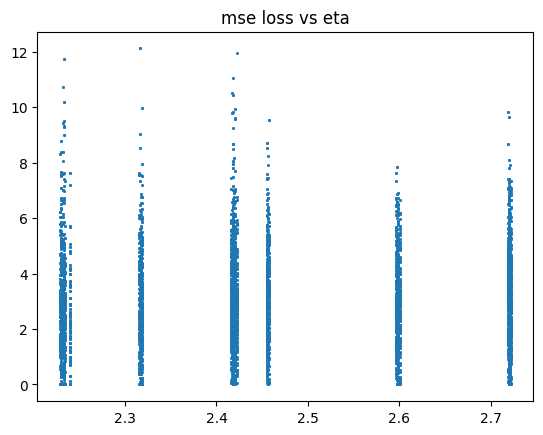

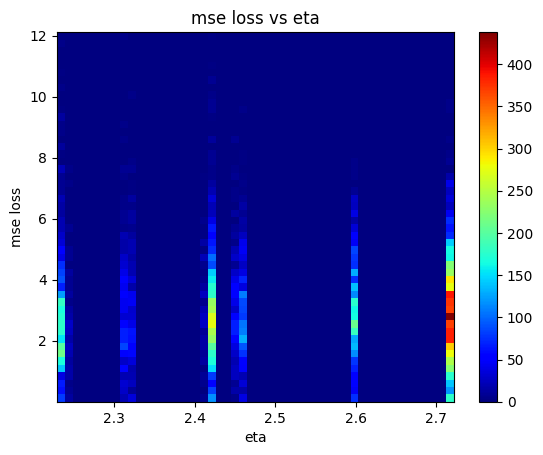

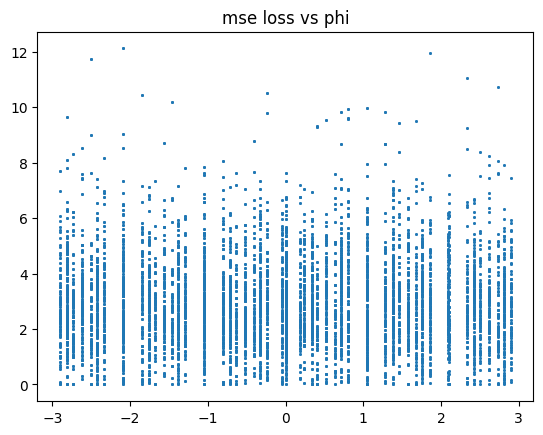

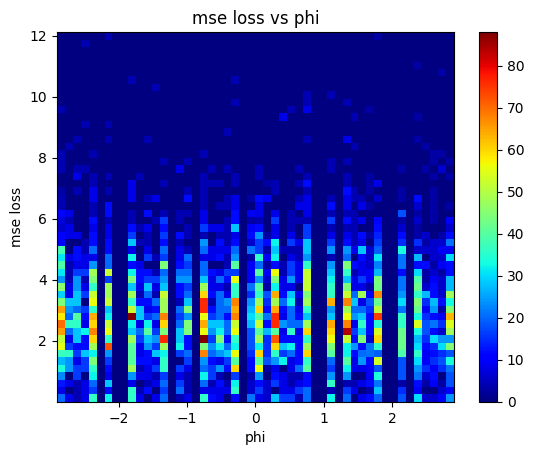

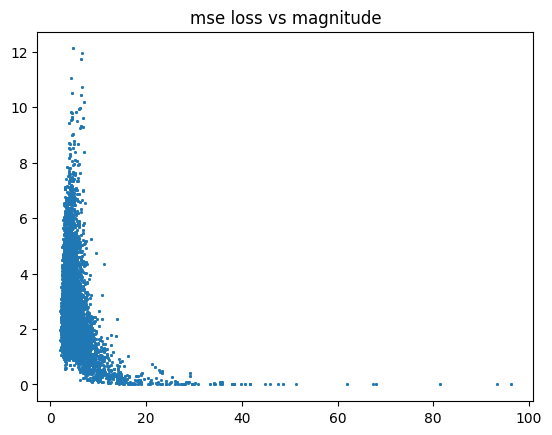

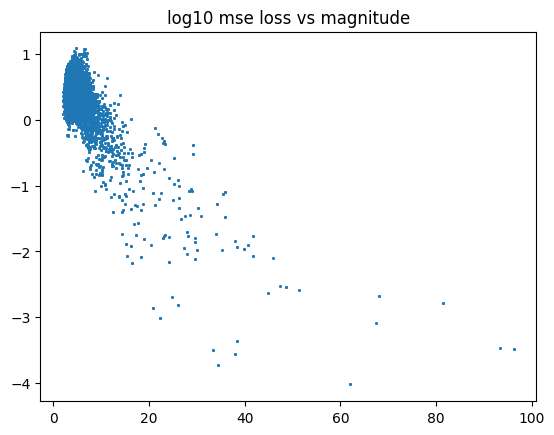

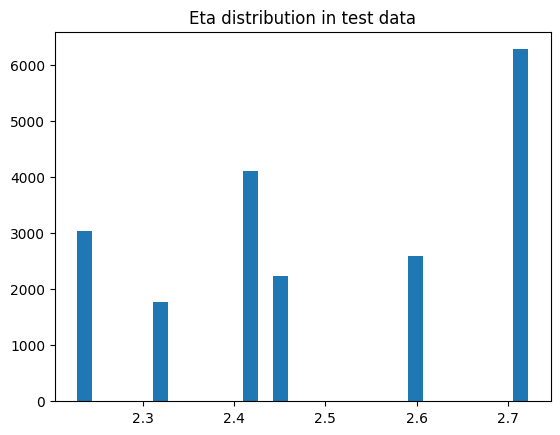

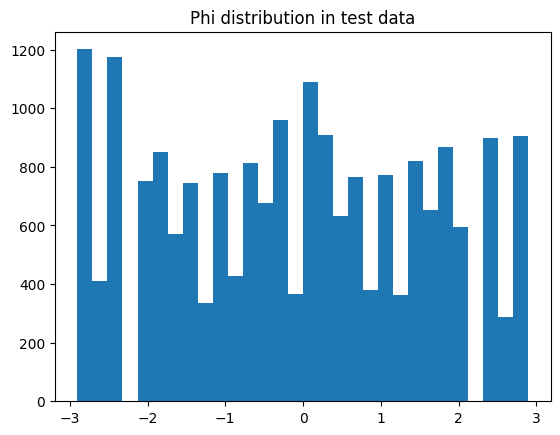

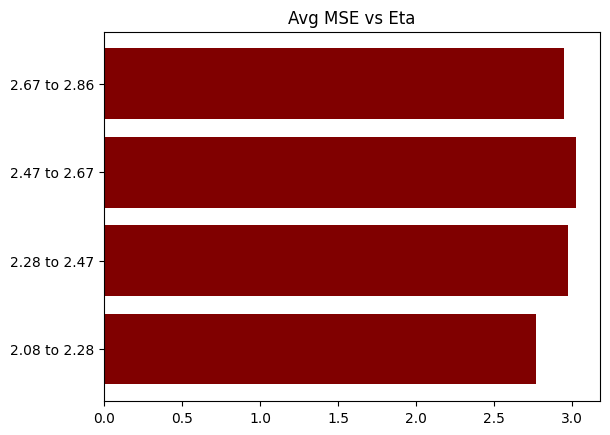

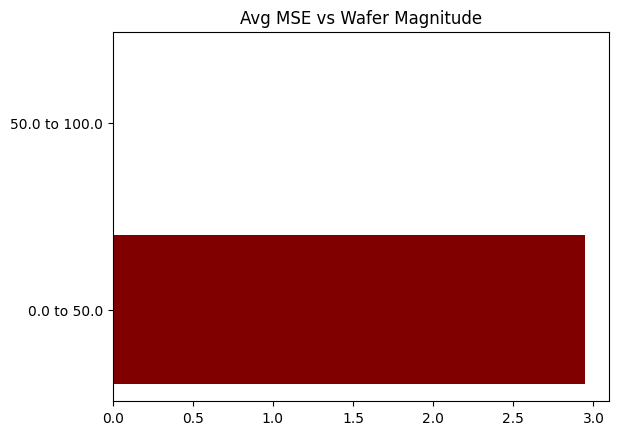

tensor([[ 2.4208, -2.9021,  5.0088,  4.7280,  9.7259],
        [ 2.4208, -2.9021,  9.5540,  0.8167,  4.1502],
        [ 2.4208, -2.9021,  2.8977,  3.8564,  9.1303],
        ...,
        [ 2.2403, -0.6381,  3.5652,  2.3373,  7.1961],
        [ 2.2403, -0.6381,  4.1339,  3.5765,  8.8353],
        [ 2.2403, -0.6381,  3.0976,  1.8539,  7.0456]], grad_fn=<CatBackward0>)

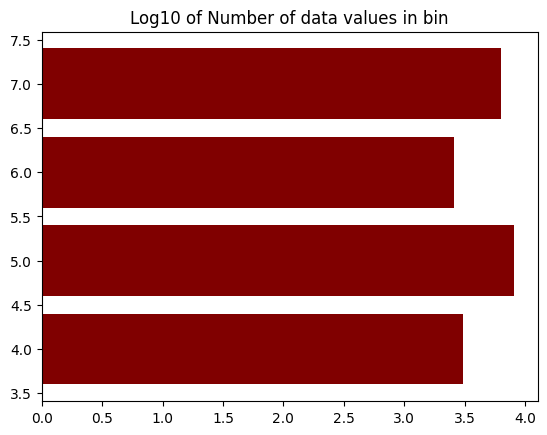

In [11]:
#fine-tune autoencoder
#batch 500

# model_1 = Naive_DAE([48,250,100,16])
model_1 = torch.load('models/dt_1_greater_0_450_250_100_dif_2')
test = dt_1[-size_test:,0:48]

a = 0.001

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
test = dt_1[-size_test:,0:48]

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
#         batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt_1,mean_dt_1,alpha = a) # difference between actual and reconstructed   
        batch_loss = loss(data[:,0:48], v_pred)
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_1.eval()
    test_pred = model_1(data_test)
    batch_test = loss(data_test[:,0:48], test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_1.eval()
AE_Stats.gen_all_stats(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48],dt_1[-size_test:])
# torch.save(model_1,'models/dt_1_greater_0_800_250_100_dif')

In [88]:
pred = model_1(dt_1[-size_test:,0:48])
data = dt_1[-size_test:,0:48]
torch.mean(torch.max(torch.ones(len(data)),1.5-0.12*((torch.sum(data[:,0:48]**2,dim=1)**0.5)-5.2586)**2)*(torch.sum((data-pred)**2,dim=1)))


tensor(6.2447, grad_fn=<MeanBackward0>)

In [86]:
torch.max(torch.ones(len(data)),1.5-0.12*((torch.sum(data[:,0:48]**2,dim=1)**0.5)-5.2586)**2)

tensor([1.4163, 1.0000, 1.2392,  ..., 1.1559, 1.3482, 1.0000])

In [85]:
torch.ones(len(data))

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [76]:
torch.mean(dt_1[-size_test:,0:48].norm(dim=1))

tensor(5.2586)

MSE 6.754959583282471
Median 5.9745683670043945
Standard Devitaion 4.399789810180664
Average std error 13.078150749206543
Average % Error of Energy Reconstruction 69.74629974365234


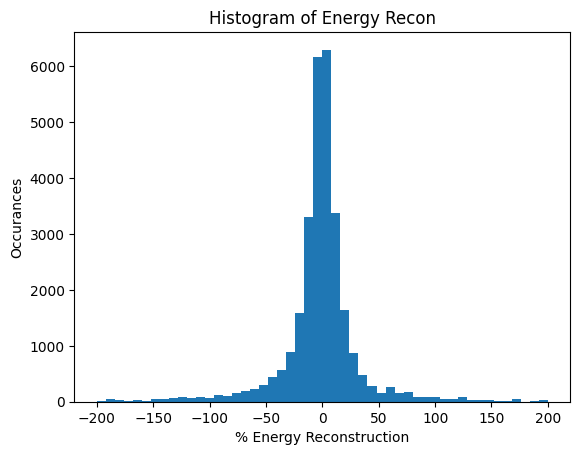

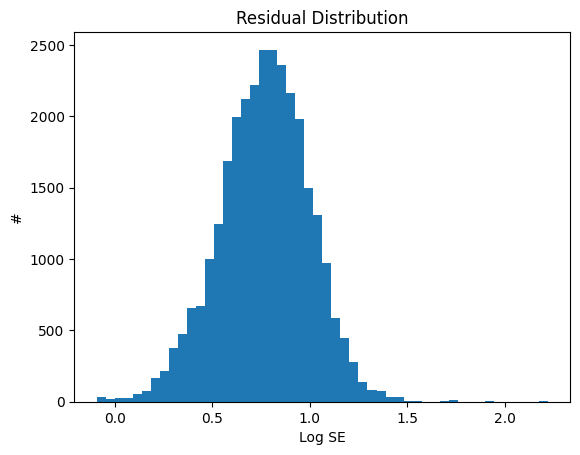

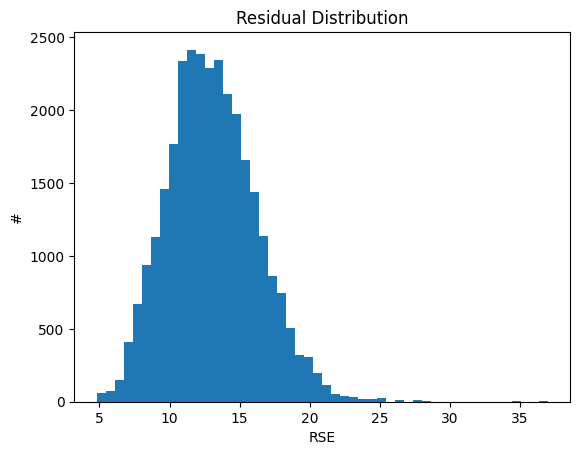

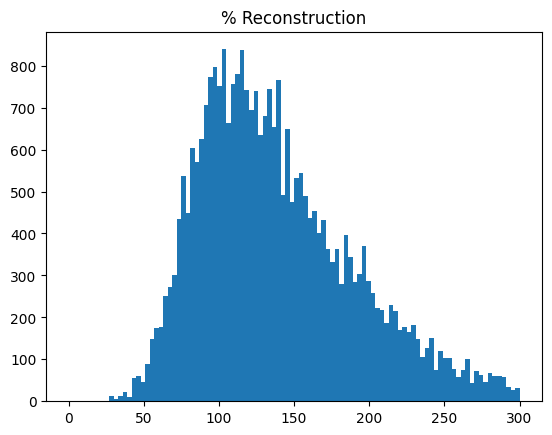

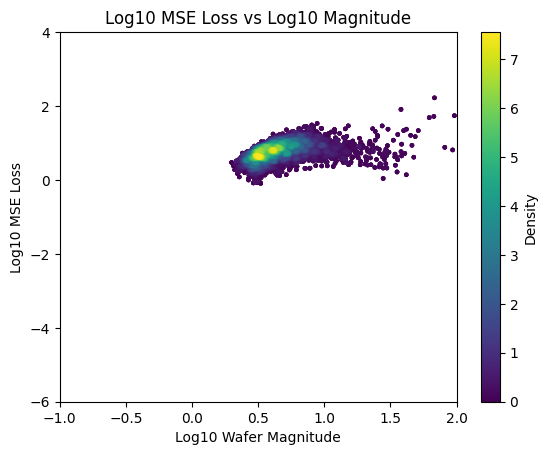

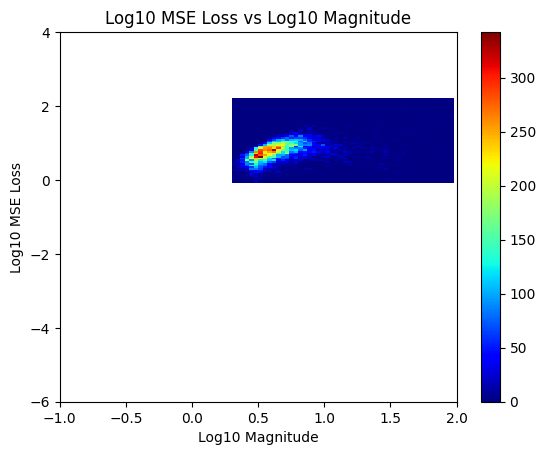

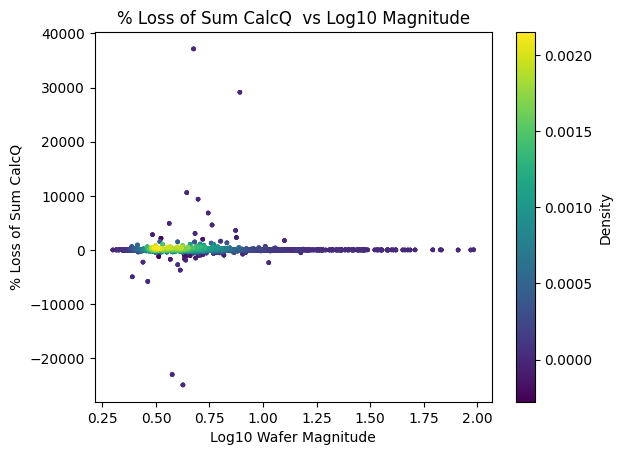

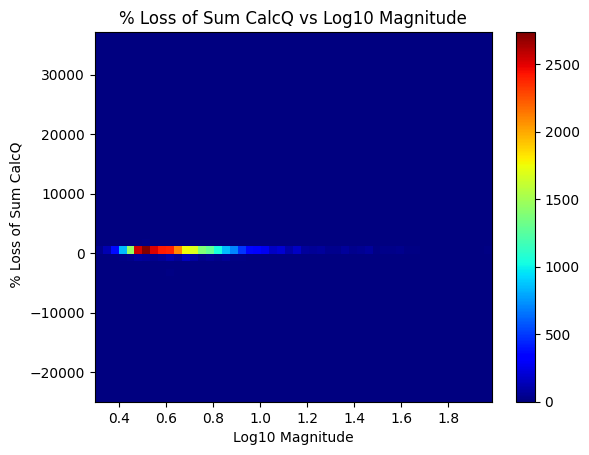

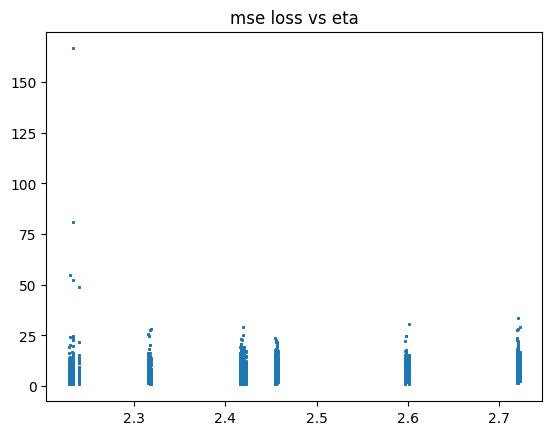

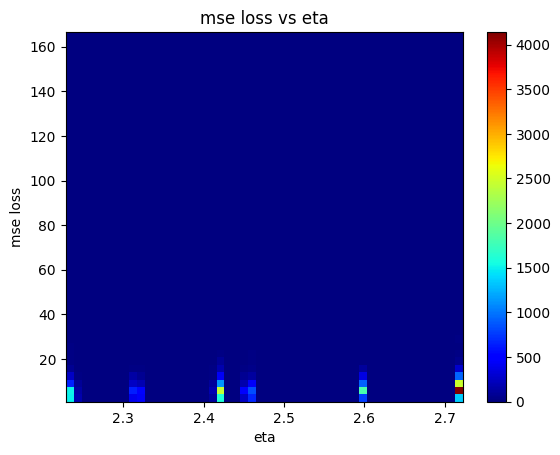

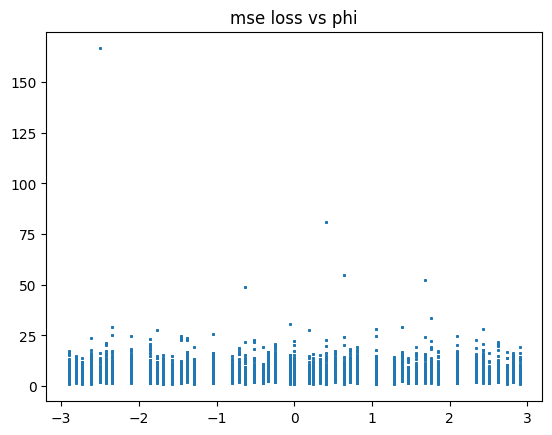

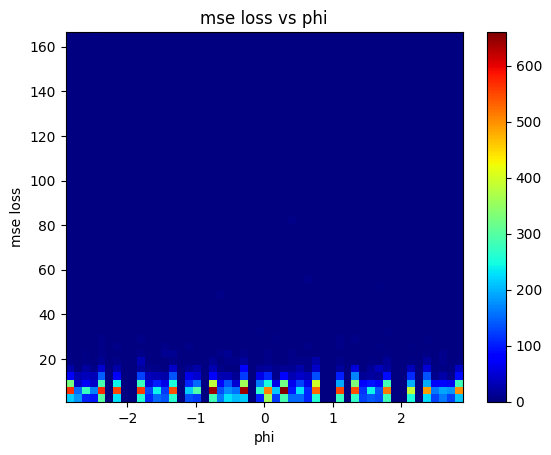

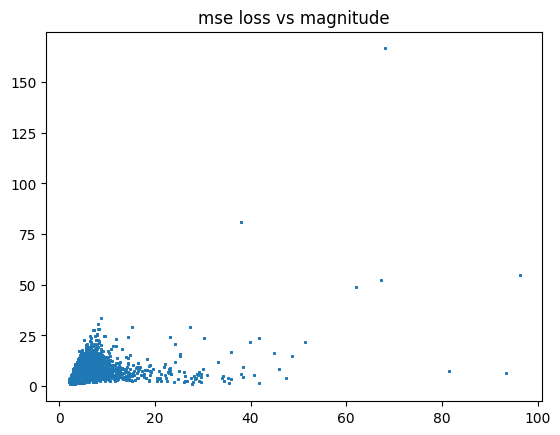

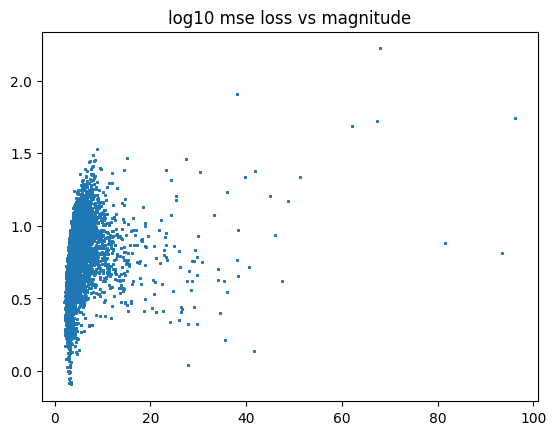

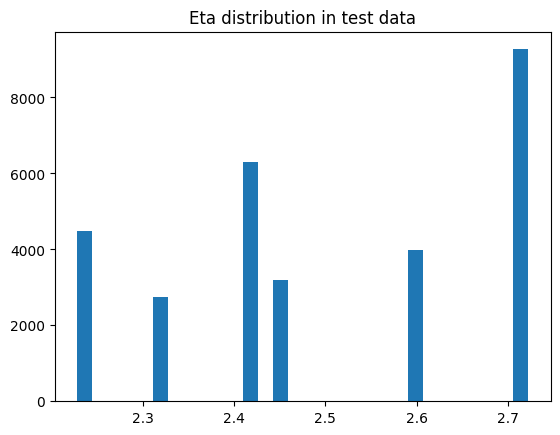

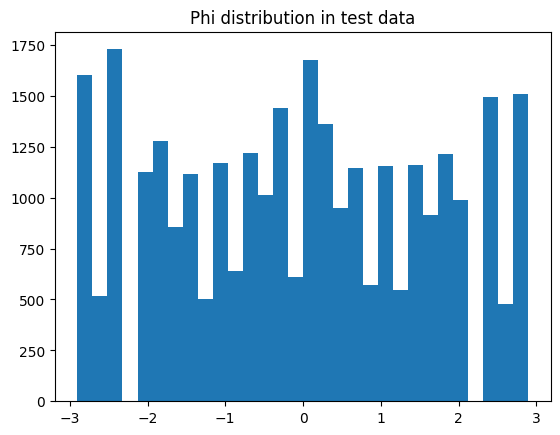

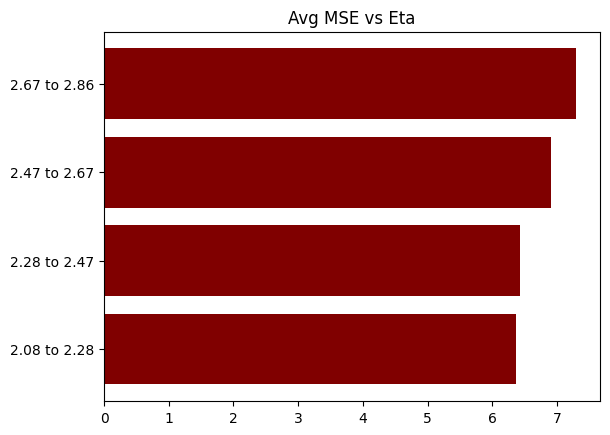

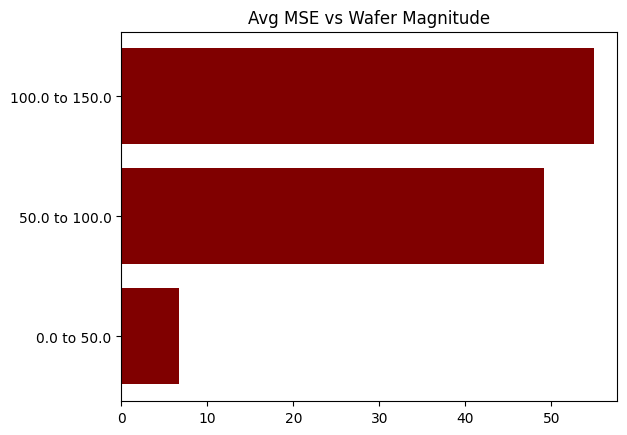

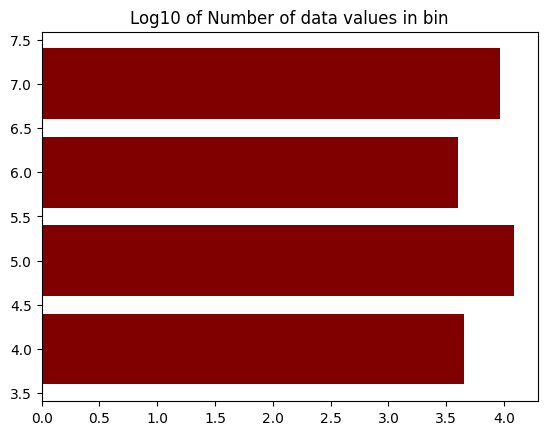

In [18]:
#fine-tune autoencoder
#batch 500

# model_1 = Naive_DAE([48,450,250,100,16])
# model_1 = torch.load('models/dt_1_greater_0_450_250_100_dif')
test = dt_1[-size_test:,0:48]

a = 0.5

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
test = dt_1[-size_test:,0:48]

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch,std_dt_1,mean_dt_1,alpha = a) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_1.eval()
    test_pred = model_1(data_test)
    batch_test = loss(data_test[:,0:48], test_pred,epoch,std_dt_1,mean_dt_1,alpha = a)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_1.eval()
AE_Stats.gen_all_stats(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48],dt_1[-size_test:])
torch.save(model_1,'models/dt_1_greater_0_450_250_100_dif_high_alpha')

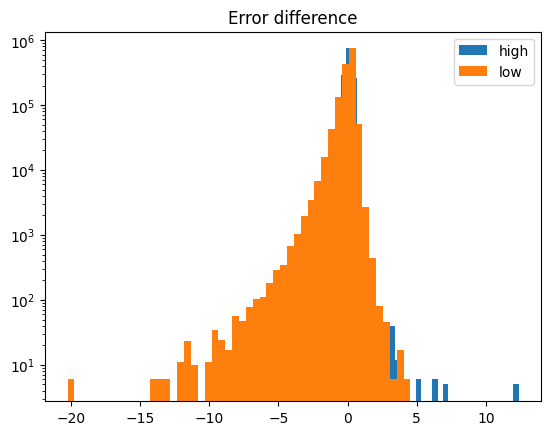

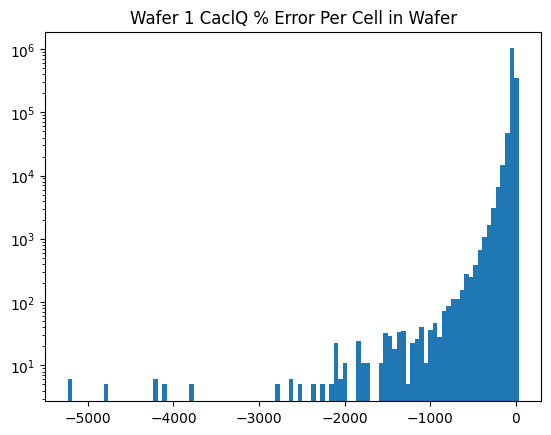

In [33]:
#Test sort of esemble AE













# m1 = torch.load('models/dt_1_greater_0_450_250_100_dif_high_alpha')
# m2 = torch.load('models/dt_1_greater_0_450_250_100_dif_low_alpha')

# test = dt_1[-size_test:,0:48]

# m1_out = m1(test)
# m2_out = m2(test)

plt.title("Error difference")
plt.hist(torch.flatten(m1_out-test).detach().numpy(),bins = 50,label = 'high',log = True)
plt.hist(torch.flatten(m2_out-test).detach().numpy(), bins = 50, label = 'low',log = True)
plt.legend()
plt.show()



max_pool = torch.max(m1_out*std_dt_1+mean_dt_1,m2_out*std_dt_1+mean_dt_1)

dif = test-max_pool
plt.title('Wafer 1 CaclQ % Error Per Cell in Wafer')
plt.hist(torch.flatten(dif).detach().numpy(),bins = 100, log = True)
plt.show()

In [29]:
torch.save(model_1,'models/dt_1_greater_0_450_250_100_dif_low_alpha')

In [38]:
(test*std_dt_1+mean_dt_1).max()

tensor(5004.)

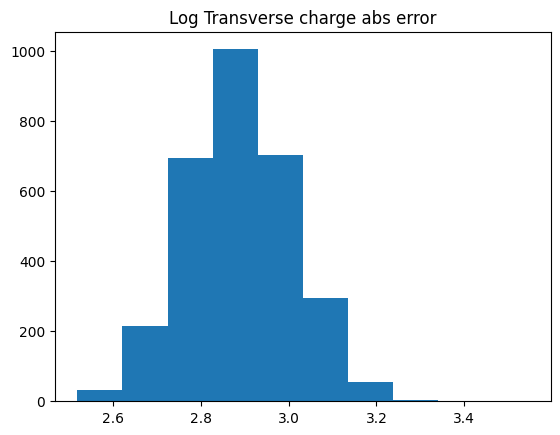

In [49]:
plt.title('Log Transverse charge abs error')
plt.hist(np.log10((torch.sum(torch.abs(model_1(dt_1[-size_test:,0:48])-dt_1[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1).detach().numpy()))
plt.show()

In [30]:
std_dt_1

tensor(51.7701)

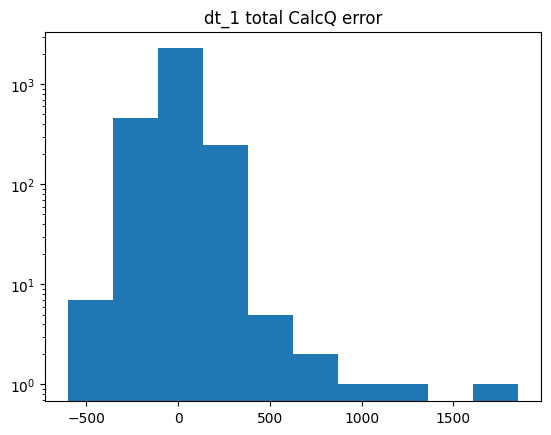

In [50]:
plt.title('dt_1 total CalcQ error')
plt.hist((torch.sum(dt_1[-size_test:,0:48]*std_dt_1+mean_dt_1,dim=1)-torch.sum(model_1(dt_1[-size_test:,0:48])*std_dt_1+mean_dt_1,dim=1)).detach().numpy(),log = True)
plt.show()

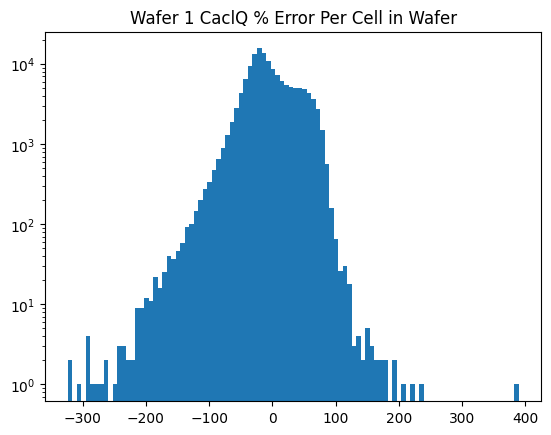

In [51]:
plt.title('Wafer 1 CaclQ % Error Per Cell in Wafer')
plt.hist((torch.flatten((((dt_1[-size_test:,0:48]-model_1(dt_1[-size_test:,0:48]))).detach())*std_dt_1)/(torch.flatten(dt_1[-size_test:,0:48]).abs()*std_dt_1 + mean_dt_1)).numpy()*100,bins = 100, log = True)
plt.show()

In [59]:
print(f'New Loss total: {new_loss(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48],epoch =10000)}')
print(f'MSE: {AE_MSE(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48]).item()}')
print(f'Average of total wafer calcq error / std: {std_error(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48])}')
print(f'Average Error in transverse charge: {calcQ_Error(model_1(dt_1[-size_test:,0:48]),dt_1[-size_test:,0:48], mean_dt_1,std_dt_1)}')

TypeError: new_loss() missing 2 required positional arguments: 'mean' and 'std'